In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sys 
import os

# TODO: make more pythonic
# this line walks up file directory so rule-vetting is cwd
# Currently this breaks if chunk is run multiple times
os.chdir(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
print(os.getcwd())

/accounts/grad/wtorous/rule-vetting


In [2]:
import rulevetting.api.viz as viz
from rulevetting.projects.csi_pecarn.dataset import Dataset

In [3]:
eda_df = Dataset().get_data()

/usr/local/linux/anaconda3.8/lib/python3.8/site-packages/pandas/core/frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


split_data kwargs {'control_types': ['ran', 'moi', 'ems']}
['ran', 'moi', 'ems']


In [23]:
eda_df = eda_df[0]

KeyError: 0

In [25]:
posthoc_columns = [col for col in eda_df.columns if 'posthoc' in col]
eda_df.drop(posthoc_columns,axis=1,inplace=True)

In [26]:
print(list(eda_df.shape))

[1704, 62]


In [27]:
outcome_def = 'csi_injury'

In [28]:
print(eda_df.shape)

(1704, 62)


In [29]:
eda_df.columns

Index(['AlteredMentalStatus', 'LOC', 'FocalNeuroFindings', 'PainNeck',
       'PosMidNeckTenderness', 'TenderNeck', 'Torticollis', 'SubInj_Head',
       'SubInj_Face', 'SubInj_Ext', 'SubInj_TorsoTrunk', 'Predisposed',
       'HighriskDiving', 'HighriskFall', 'HighriskHanging', 'HighriskHitByCar',
       'HighriskMVC', 'HighriskOtherMV', 'AxialLoadAnyDoc', 'axialloadtop',
       'Clotheslining', 'CervicalSpineImmobilization', 'GCSEye', 'MotorGCS',
       'VerbalGCS', 'TotalGCS', 'PtCompPainFace', 'PtCompPainHead',
       'PtTenderNeck', 'PtTenderFace', 'PtTenderHead', 'PassRestraint',
       'Assault', 'ChildAbuse', 'csi_injury', 'EMSArrival', 'NonAmbulatory',
       'AVPUDetails_AVPU_A', 'AVPUDetails_AVPU_P', 'AVPUDetails_AVPU_U',
       'AVPUDetails_AVPU_V', 'AVPUDetails_AVPU_nan',
       'ReceivedInTransfer_binary', 'PtAmbulatoryPriorArrival_binary',
       'ArrPtIntub_binary', 'PtCompPainNeckMove_binary',
       'CervicalSpineImmobilization_outside_binary', 'helmet_binary',
       '

In [9]:
# get list of columns with only two recorded outcomes
binary_columns = eda_df.columns[eda_df.nunique()==2]
binary_eda_data = eda_df.loc[:,binary_columns].copy() 

cont_columns = eda_df.columns[eda_df.nunique()!=2]
cont_eda_data = eda_df.loc[:,cont_columns].copy()
cont_eda_data.loc[:,outcome_def] = eda_df.loc[:,outcome_def].copy() #add binary outcome indicator back in

In [10]:
# outcome indicator is double counted
print(eda_df.shape)
print(binary_eda_data.shape)
print(cont_eda_data.shape)

(1704, 94)
(1704, 85)
(1704, 10)


In [11]:
print(cont_eda_data.head())

                                  GCSEye  MotorGCS  VerbalGCS  TotalGCS  \
id     case_id site control_type                                          
110001 110001  1    case             1.0       1.0        1.0       3.0   
110021 110021  1    case             4.0       6.0        5.0      15.0   
110019 110019  1    case             4.0       6.0        5.0      15.0   
110002 110002  1    case             4.0       6.0        5.0      15.0   
110011 110011  1    case             4.0       6.0        5.0      15.0   

                                               posthoc_Race posthoc_PayorType  \
id     case_id site control_type                                                
110001 110001  1    case                              White                CI   
110021 110021  1    case                              White                ND   
110019 110019  1    case                              White                CI   
110002 110002  1    case          Black or African American          

In [12]:
print(np.unique(eda_df.index.get_level_values('control_type')))

['case' 'ems' 'moi' 'ran']


# Summary EDA

In [13]:
eda_df.describe()

,AlteredMentalStatus,LOC,FocalNeuroFindings,PainNeck,PosMidNeckTenderness,TenderNeck,Torticollis,SubInj_Head,SubInj_Face,SubInj_Ext,...,Xrays_outside_binary,CTPerformed_outside_binary,MRIPerformed_outside_binary,posthoc_Xrays_site_binary,posthoc_CTPerformed_site_binary,posthoc_MRIPerformed_site_binary,NonVerbal,YoungAdult,HighRiskFallDownStairs,PainNeck_Robust
count,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,...,1704.000000,1704.00000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000,1704.000000
mean,0.178404,0.365610,0.115023,0.329225,0.284038,0.370892,0.054577,0.120892,0.051643,0.090376,...,0.027582,0.02054,0.000587,0.920775,0.327465,0.122066,0.191315,0.457160,0.023474,0.343310
std,0.382965,0.481742,0.319144,0.470070,0.451087,0.483185,0.227220,0.326097,0.221371,0.286803,...,0.163820,0.14188,0.024225,0.270169,0.469426,0.327458,0.393452,0.498308,0.151448,0.474953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
binary_corrs = binary_eda_data.corr(method='spearman')
cont_corrs = cont_eda_data.corr(method='spearman')

print(cont_corrs)

              GCSEye  MotorGCS  VerbalGCS  TotalGCS  csi_injury
GCSEye      1.000000  0.815939   0.790269  0.832520   -0.138851
MotorGCS    0.815939  1.000000   0.846215  0.866670   -0.169392
VerbalGCS   0.790269  0.846215   1.000000  0.951456   -0.156315
TotalGCS    0.832520  0.866670   0.951456  1.000000   -0.155685
csi_injury -0.138851 -0.169392  -0.156315 -0.155685    1.000000


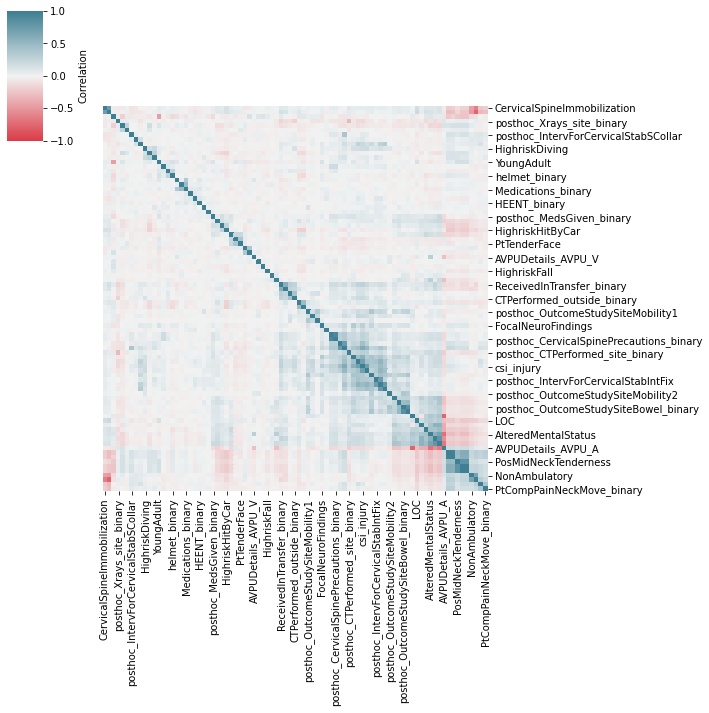

In [15]:
binary_corrmap = sns.clustermap(binary_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
binary_corrmap.ax_row_dendrogram.set_visible(False)
binary_corrmap.ax_col_dendrogram.set_visible(False)

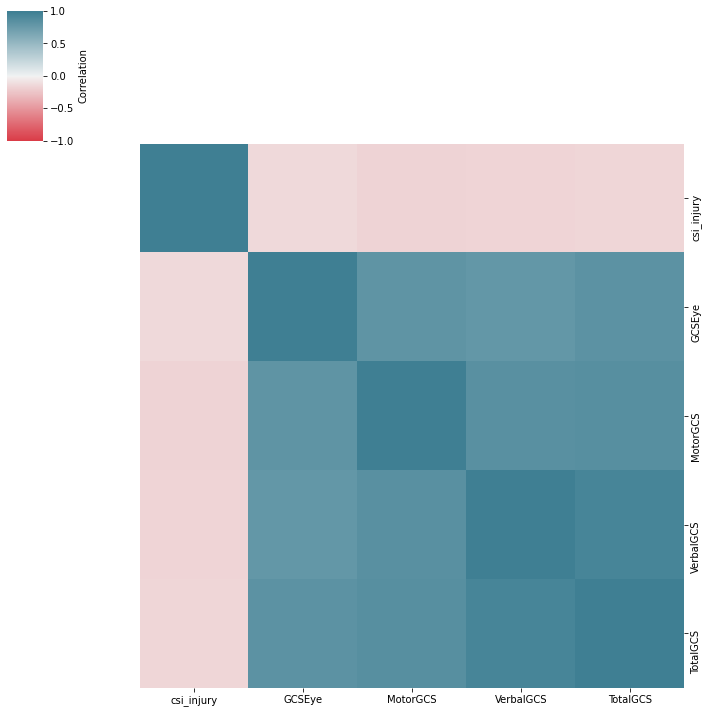

In [16]:
cont_corrmap = sns.clustermap(cont_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
cont_corrmap.ax_row_dendrogram.set_visible(False)
cont_corrmap.ax_col_dendrogram.set_visible(False)

In [17]:
print(binary_corrs)

                                  AlteredMentalStatus       LOC  \
AlteredMentalStatus                          1.000000  0.324184   
LOC                                          0.324184  1.000000   
FocalNeuroFindings                           0.053006 -0.006339   
PainNeck                                    -0.284057 -0.223279   
PosMidNeckTenderness                        -0.225523 -0.156604   
...                                               ...       ...   
posthoc_MRIPerformed_site_binary             0.154015  0.074272   
NonVerbal                                    0.116289 -0.031565   
YoungAdult                                  -0.070699  0.144783   
HighRiskFallDownStairs                      -0.011503 -0.021122   
PainNeck_Robust                             -0.285274 -0.228104   

                                  FocalNeuroFindings  PainNeck  \
AlteredMentalStatus                         0.053006 -0.284057   
LOC                                        -0.006339 -0.223279 

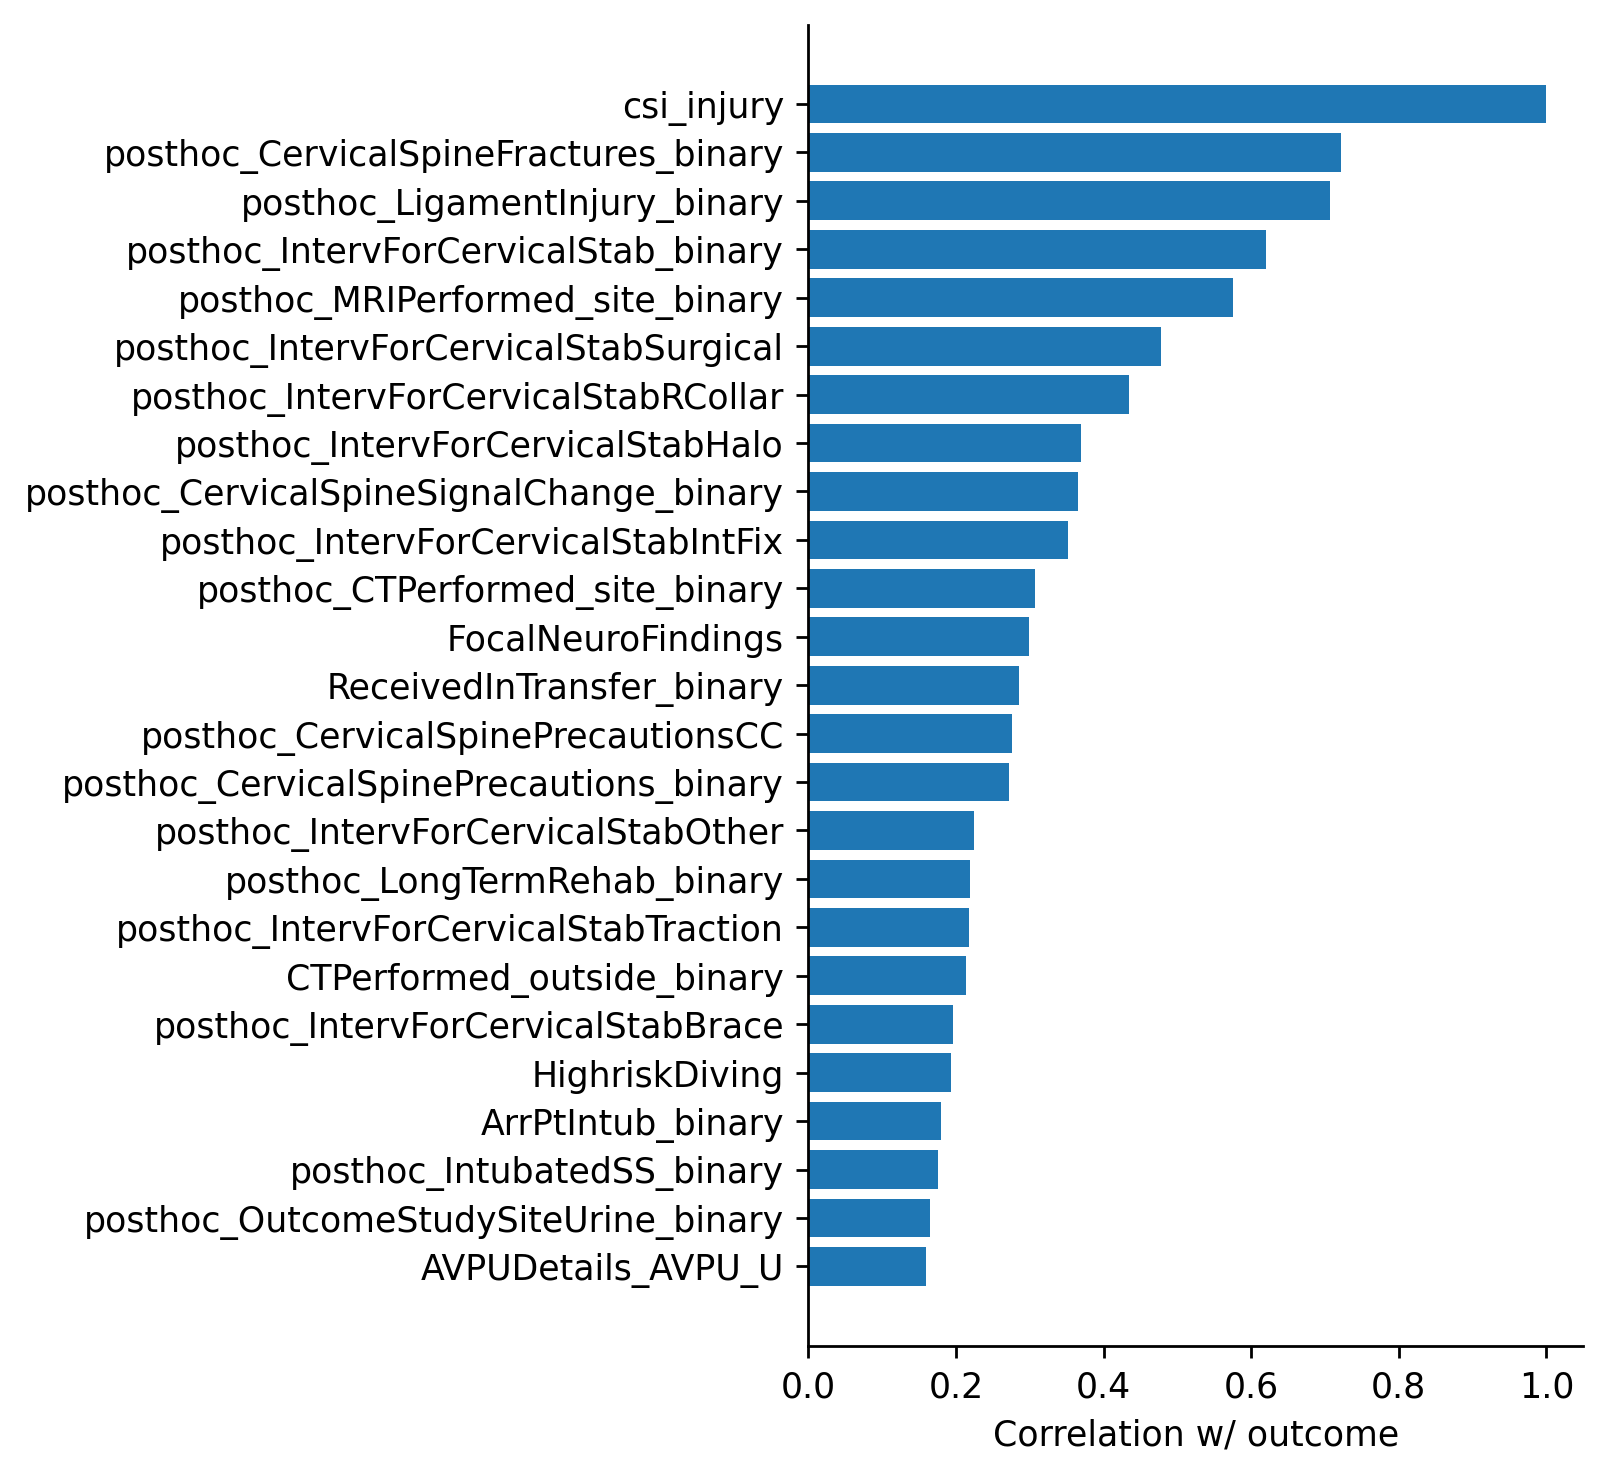

In [18]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[-25:], vals[args][-25:])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

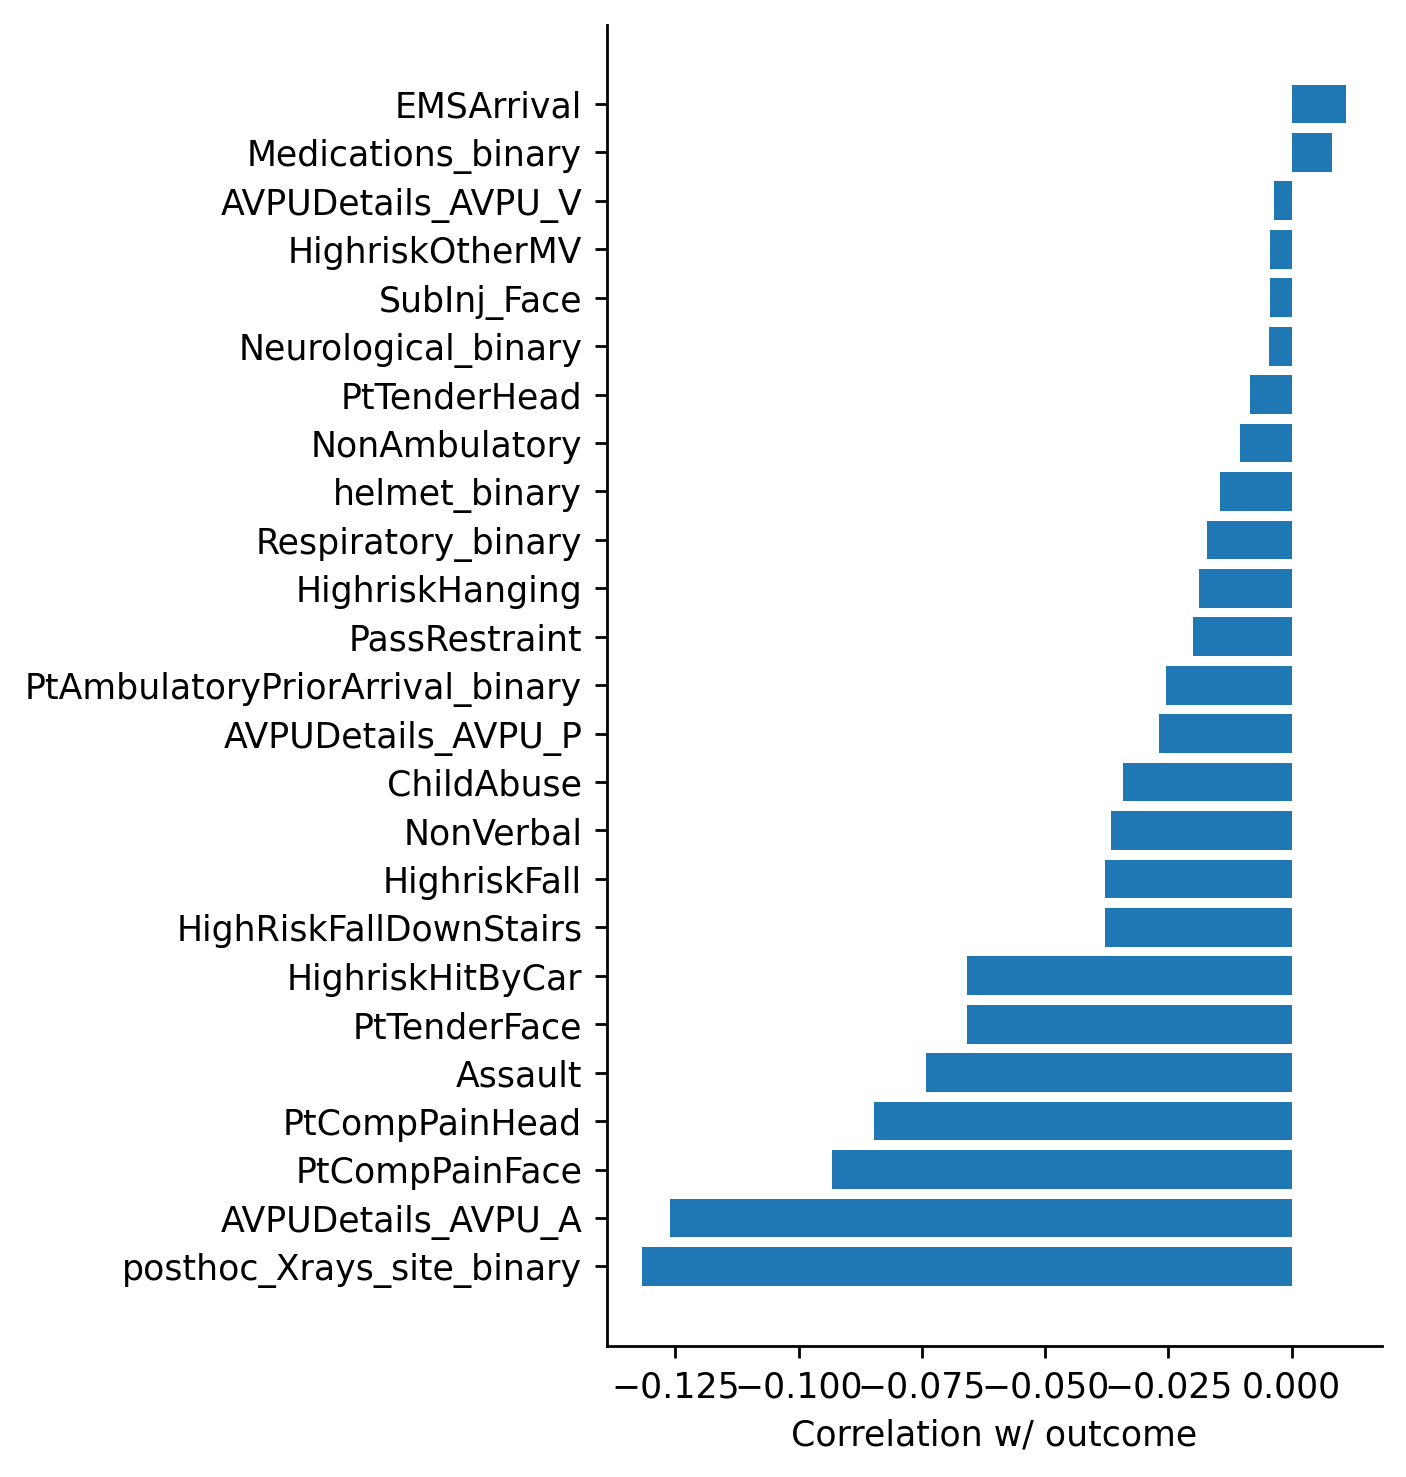

In [19]:
plt.figure(dpi=250, figsize=(4, 7))
vals = binary_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs[:25], vals[args][:25])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

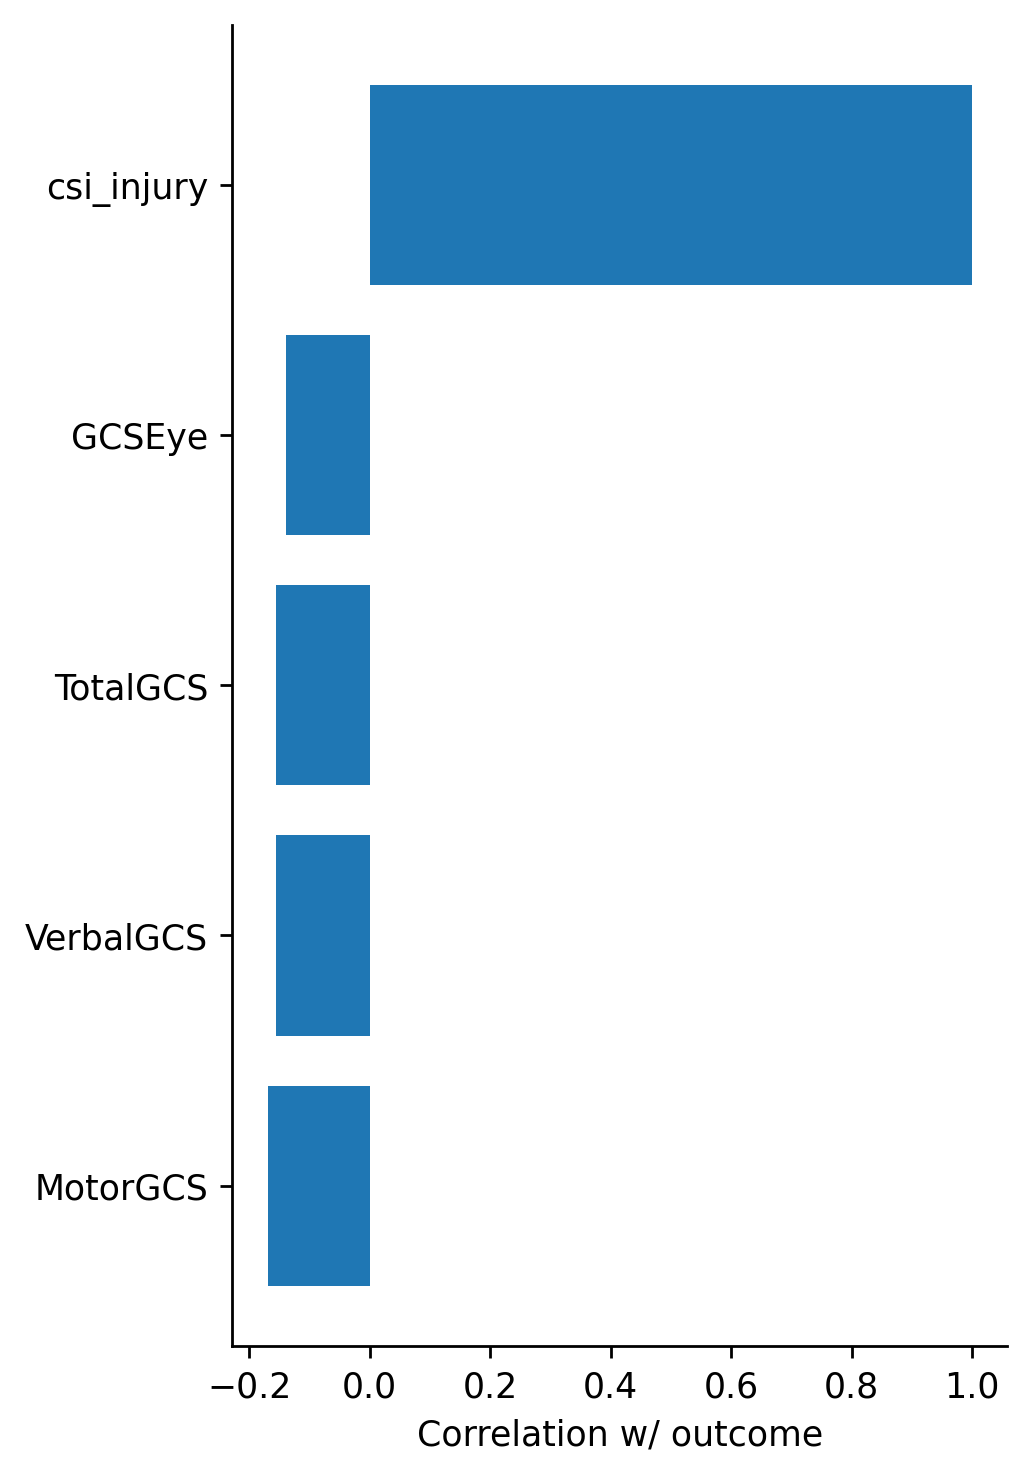

In [20]:
plt.figure(dpi=250, figsize=(4, 7))
vals = cont_corrs[outcome_def]
args = np.argsort(vals)
labs = vals.index.values[args]
ax = plt.subplot(111)
plt.barh(labs, vals[args])
plt.xlabel('Correlation w/ outcome')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# EDA of Missingness

In [21]:
# get percent missing by column
pd.set_option("display.max_rows", None, "display.max_columns", None)
print("25 Covariates with Highest Percent Missingness\n")
print("All Covariates:")
missing_frac = (eda_df.isna().sum() / eda_df.shape[0]) * 100
print(missing_frac.sort_values(ascending=False)[:])

25 Covariates with Highest Percent Missingness

All Covariates:
AlteredMentalStatus                           0.0
posthoc_CervicalSpinePrecautions_binary       0.0
posthoc_CervicalSpineFractures_binary         0.0
CervicalSpineImmobilization_outside_binary    0.0
posthoc_TrfToLongTermRehab_binary             0.0
posthoc_LongTermRehab_binary                  0.0
posthoc_IntubatedSS_binary                    0.0
posthoc_MedsGiven_binary                      0.0
posthoc_OutcomeStudySiteUrine_binary          0.0
posthoc_OutcomeStudySiteBowel_binary          0.0
posthoc_IntervForCervicalStab_binary          0.0
PtCompPainNeckMove_binary                     0.0
posthoc_CervicalSpineSignalChange_binary      0.0
ArrPtIntub_binary                             0.0
PtAmbulatoryPriorArrival_binary               0.0
ReceivedInTransfer_binary                     0.0
AVPUDetails_AVPU_nan                          0.0
AVPUDetails_AVPU_V                            0.0
AVPUDetails_AVPU_U                  

In [22]:
complete_binary_covar = binary_columns[bin_missing_frac==0]
print("Binary covar. with no missing data:",len(complete_binary_covar))

missing_columns = binary_columns[bin_missing_frac!=0]
print("Binary covar. with some missing data:",len(missing_columns))

NameError: name 'bin_missing_frac' is not defined

In [ ]:
binary_missing_bools = binary_eda_data[missing_columns].isna()
binary_missing_corrs = binary_missing_bools.corr(method='spearman')

In [ ]:
corrmap = sns.clustermap(binary_missing_corrs, cmap=viz.cmap_div, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
corrmap.ax_row_dendrogram.set_visible(False)
corrmap.ax_col_dendrogram.set_visible(False)

In [ ]:
print(max(binary_missing_corrs))

In [ ]:
print(sorted(binary_missing_corrs.iloc[:,3]))

# EDA of Demographic Data

In [ ]:
eda_demographic_df = pd.read_csv("data/csi_pecarn/raw/demographics.csv").set_index(["studysubjectid"])
print(eda_demographic_df.columns)

In [ ]:
gender_df = eda_demographic_df.groupby('site')['Gender'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Gender Variable Across Study Sites')
gender_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
race_df = eda_demographic_df.groupby('site')['Race'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Race Variable Across Study Sites')
race_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
ethnicity_df = eda_demographic_df.groupby('site')['Ethnicity'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Ethnicity Variable Across Study Sites')
ethnicity_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
payor_df = eda_demographic_df.groupby('site')['PayorType'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Payor Type Across Study Sites')
payor_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()

In [ ]:
age_df = eda_demographic_df[['site','AgeInYears']]


bins = [0, 2, 5, 10, 13, np.inf]
names = ['<2', '2-5', '5-10', '10-13', '13+']

age_df.loc[:,['AgeBin']] = pd.cut(age_df.loc[:,'AgeInYears'], bins, labels=names)

age_range_df = age_df.groupby('site')['AgeBin'].value_counts(normalize=True)

fig = plt.figure()
plt.title('Summary of Age Range Across Study Sites')
age_range_df.unstack().plot(kind='bar', stacked=True,ax=fig.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation = 0)
plt.show()
